In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
trainPCADf = pd.read_csv('trainTPCA.csv')
testPCADf = pd.read_csv('testTPCA.csv')
trainPCADf = trainPCADf.drop(['Unnamed: 0'],1)
testPCADf = testPCADf.drop(['Unnamed: 0'],1)

## Data Preparation

In [3]:
dateStream = pd.read_csv('songRegionStreams.csv')
dateStream = dateStream.drop(['Unnamed: 0'],1)

In [4]:
dateStream.dtypes

Track Name    object
Artist        object
Position       int64
Streams        int64
Date          object
Region        object
dtype: object

In [5]:
dateStream = pd.concat([dateStream,pd.get_dummies(dateStream.Region)],1)
dateStream['Date'] = pd.to_datetime(dateStream.Date)
dateStream['Month'] = [x.month for x in dateStream.Date]
dateStream['Day'] = [x.day for x in dateStream.Date]
#dateStream[dateStream.columns[6:]] = dateStream[dateStream.columns[6:]].astype(float)
#dateStream[dateStream.columns[2:4]] = dateStream[dateStream.columns[2:4]].astype(float)

In [6]:
trainStream = dateStream.merge(trainPCADf,on=['Track Name','Artist'])
testStream = dateStream.merge(testPCADf,on=['Track Name','Artist'])

In [ ]:
trainStream

In [10]:
# split into model type then split into X and Y
def splitModelXY(trainData,modelNumber):
    trainMod = trainData[trainData['Clabel'] == modelNumber]
    XtrainMod = trainMod.sort_values('Date').reset_index(drop=True)
    trainScale = StandardScaler()
    YtrainMod = np.asarray(np.log(XtrainMod.Streams))
    XtrainMod = np.asarray(XtrainMod[XtrainMod.columns[6:-1]].values)
    XtrainMod = trainScale.fit_transform(XtrainMod)
    return (XtrainMod,YtrainMod,trainScale)
    

In [11]:
trainX1, trainY1, train1Scale1 = splitModelXY(trainStream,1)
trainX0, trainY0, train1Scale0 = splitModelXY(trainStream,0)

In [12]:
print(trainX1.shape)
print(trainX0.shape)

(116067, 36)
(337476, 36)


In [13]:
## handling test data
def splitModelXYTest(trainData,modelNumber,scalObj):
    trainMod = trainData[trainData['Clabel'] == modelNumber]
    artistSong = trainMod.drop_duplicates(['Track Name','Artist'])
    songCollection = []
    for i,r in artistSong.iterrows():
        sModel = trainMod[(trainMod['Track Name'] == r['Track Name']) \
                          & (trainMod['Artist'] == r['Artist'])]
        
        sModel = sModel.sort_values('Date').reset_index(drop=True)
        syMod = np.asarray(np.log(sModel.Streams))
        sxMod = np.asarray(sModel[sModel.columns[6:-1]].values)
        sxMod = scalObj.transform(sxMod)
        songCollection.append((r['Artist'],r['Track Name'],sxMod,syMod,sModel.Region,sModel.Date))
    return songCollection

In [14]:
testSong1 = splitModelXYTest(testStream,1,train1Scale1)
testSong0 = splitModelXYTest(testStream,0,train1Scale0)

In [15]:
print(len(testSong1))
print(len(testSong0))

272
1020


## Online Learning

In [17]:
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor

In [19]:
## MLP Regressor
mlp1 = MLPRegressor(hidden_layer_sizes=100,max_iter=300,alpha=0.001).fit(trainX1,trainY1)
mlp0 = MLPRegressor(hidden_layer_sizes=100,max_iter=300,alpha=0.001).fit(trainX0,trainY0)

In [20]:
## Initial testing then we can cross validate 
def generatePredictions(testSongArr,trainedModel):
    
    testSongtotal = []
    for a,b,tx,ty,r,d in testSongArr:
        predictedValue = []
        for j in range(len(ty)):
            predictedValue.append(trainedModel.predict(tx[j,:].reshape(1, -1)))
            trainedModel.partial_fit(tx[j,:].reshape(1, -1),np.array([ty[j]]))
        testSongtotal.append((a,b,tx,ty,predictedValue,r,d))
    return testSongtotal
    

In [21]:
testSong1Full = generatePredictions(testSong1,mlp1)
testSong0Full = generatePredictions(testSong0,mlp0)

In [22]:
import math

# artist, title, pca, streams,predictedValue,r,d
"""
takes in testSongXFull and outputs a list of [(song, artist, region, streams[], predictions[], date[])]
"""
def process_results_1(results):
    processed_res = []
    for artist, title, pca, streams,predictedValue,r,d in results:
    #     predictedValue = [i[0] for i in predictedValue]
        reg_data = {}
        for s, p, d, r in zip(streams, predictedValue, d, r):
            if r not in reg_data:
                reg_data[r] = []
            reg_data[r].append((s, p, d))
        for r in reg_data:
            s = [x[0] for x in reg_data[r]]
            p = [x[1][0] for x in reg_data[r]]
            d = [x[2] for x in reg_data[r]]
            if len(s) < 5:
                continue
            s = s[0:min(len(s), 45)]
            p = p[0:min(len(p), 45)]
            d = d[0:min(len(d), 45)]
            res = {
                'artist' : artist,
                'song' : title,
                'region' : r,
                'dates' : d,
                'streams' : s,
                'predictions' : p
            }
            res['diff'] = [abs(st - pr) for st, pr in zip(s, p)]
            res['diff_sq'] = [x**2 for x in res['diff']]
            res['rmse'] = math.sqrt(sum(res['diff_sq']) / len(res['diff_sq']))
            res['err'] = [dif / st for st, dif in zip(s,res['diff'])]
            processed_res.append(res)
    return processed_res

In [23]:
p_res1_0 = process_results_1(testSong0Full)
p_res1_1 = process_results_1(testSong1Full)

In [24]:
def process_err(results):
    err = [0] * 45
    n_songs = [0] * 45
    err_global = [0] * 45
    n_songs_global = [0] * 45
    for res in results:
        errors = res['err']
        if res['region'] == 'us':
            for i in range(len(errors)):
                err[i] += errors[i]
                n_songs[i] += 1
        else:
            for i in range(len(errors)):
                err_global[i] += errors[i]
                n_songs_global[i] += 1
    err = [e / n if n > 0 else 0 for e, n in zip(err, n_songs)]
    err_global = [e / n if n > 0 else 0 for e, n in zip(err_global, n_songs_global)]
    return err, err_global, n_songs, n_songs_global

In [25]:
err0, err_global0, n0, n_g0 = process_err(p_res1_0)
err1, err_global1, n1, n_g1 = process_err(p_res1_1)

In [26]:
def plot_day_data(y, title, ylabel):
#     x = range(1, 46)
    plt.plot(pd.Series(y))
    plt.title(title)
    plt.xlabel('Day')
    plt.ylabel('Average Error')
    plt.show()

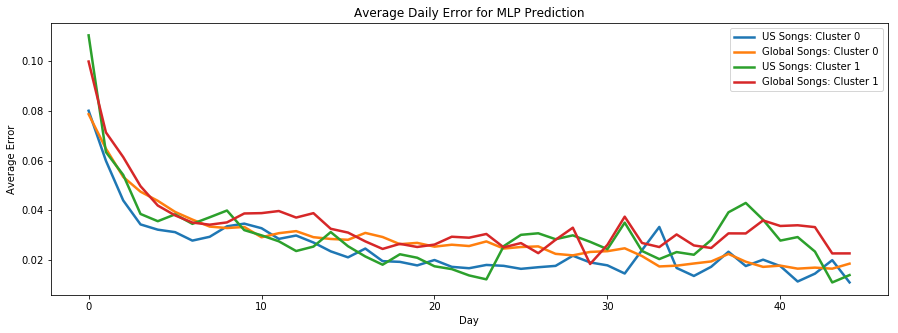

In [40]:
from pylab import rcParams

rcParams['figure.figsize'] = 15, 5

for e in [err0, err_global0, err1, err_global1]:
#     plot_day_data(e, 'Average Daily Error for MLP Prediction of US Song Streams: Cluster 0', 'Error')
    plt.plot(pd.Series(e), linewidth=2.5)

plt.title('Average Daily Error for MLP Prediction')
plt.xlabel('Day')
plt.ylabel('Average Error')
plt.legend(['US Songs: Cluster 0', 'Global Songs: Cluster 0', 'US Songs: Cluster 1', 'Global Songs: Cluster 1'])
plt.savefig('Images/MLPnoregDailyError.png')
plt.show()

In [36]:
def process_rmse(results):
    rmse = [r['rmse'] for r in results if r['region'] == 'us']
    rmse_global = [r['rmse'] for r in results if r['region'] != 'us']
    return rmse, rmse_global

rmse0, rmse_global0 = process_rmse(p_res1_0)
rmse1, rmse_global1 = process_rmse(p_res1_1)

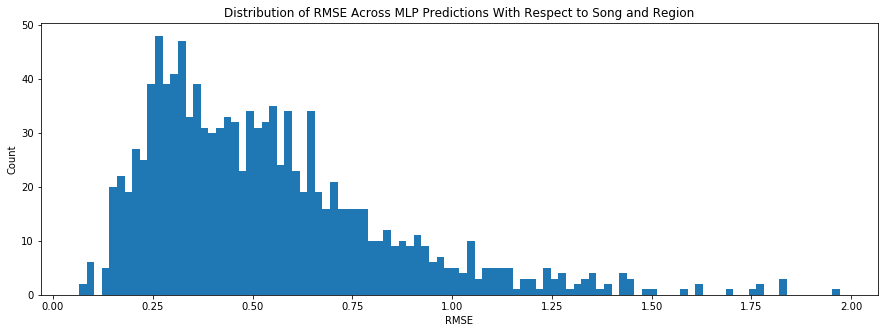

In [39]:
all_rmse = rmse0 + rmse_global0 + rmse1 + rmse_global1
plt.hist([r for r in all_rmse if r <=2], bins=100)
plt.title('Distribution of RMSE Across MLP Predictions With Respect to Song and Region')
plt.xlabel('RMSE')
plt.ylabel('Count')
plt.savefig('Images/MLPnoreg_allpredRMSE.png')
plt.show()

In [30]:
def get_total_rmse(results):
    dsq = []
    dsq_global = []
    for r in results:
        if r['region'] == 'us':
            dsq += r['diff_sq']
        else:
            dsq_global += r['diff_sq']
    rmse = math.sqrt(sum(dsq) / (1.0 * len(dsq)))
    rmse_global = math.sqrt(sum(dsq_global) / (1.0 * len(dsq_global)))
    return rmse, rmse_global

In [31]:
rmse0, rmse_global0 = get_total_rmse(p_res1_0)
rmse1, rmse_global1 = get_total_rmse(p_res1_1)
print('RMSE for US Song Predictions, cluster 0:\t%f'%rmse0)
print('RMSE for Global Song Predictions, cluster 0:\t%f'%rmse_global0)
print('RMSE for US Song Predictions, cluster 1:\t%f'%rmse1)
print('RMSE for Global Song Predictions, cluster 1:\t%f'%rmse_global1)

RMSE for US Song Predictions, cluster 0:	0.580860
RMSE for Global Song Predictions, cluster 0:	0.648624
RMSE for US Song Predictions, cluster 1:	0.757646
RMSE for Global Song Predictions, cluster 1:	0.772469
